In [141]:
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np

In [379]:
from torch.distributions import Categorical, Normal, MultivariateNormal

class Reinforce(nn.Module):
    def __init__(self, p_dim=2, state_dim=4, hidden_dim=128):
        super().__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, p_dim)
        
    def forward(self, x):
        return self.linear2(self.linear1(x))

    def sample_action(self, probs):
        # probs = torch.tensor(p)
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()
        
        return sample

# Core Components

- Generate an episode of length T. From episode we need a series of triplets ($\{S_t, A_t, R_{t+1}\}_t$) to implement REINFORCE.
- Define parametrized policy.
- Update policy parameter: Run SGD for t=0,...,T-1.
    - Compute $G \leftarrow \sum_{i=t+1}^{T} \gamma^{i-t-1}R_i$
    - $\theta_{t+1} \leftarrow \theta_t + \alpha \gamma^t G \nabla \ln \Pi(A_t | S_t, \theta_t)$

# Cartpole environment and policy
(ref: https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- Actions: Two actions: move left (0) and move right (1)
- States:
    - Cart position
    - Cart velocity
    - Pole angle
    - Pole angular velocity
- Initial state: all values randomly initialized in the range [-0.05, 0.05]
- Terminal state: Episode length greater than 500 or pole angle > 24deg or < -24deg
- Reward: +1 for each state before we reach a termial state

In [367]:
def gen_episode(env, policy, device):
    done = False
    rewards = []
    logps = []
    states = []
    obs, _ = env.reset()
    while not done:
        logits = policy(torch.as_tensor(obs, dtype=torch.float32, device=device))
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        logps.append(dist.log_prob(action))
        obs, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)
        states.append(obs)
        
        done = terminated or truncated
        # done = truncated
        
        
    return rewards, logps, states

In [104]:
def discounted_rewards(rw, discount_factor):
    R = []
    for i in range(len(rw)):
        discounted_reward = 0
        for j in range(i, len(rw)):
            discounted_reward += (discount_factor ** (j - i)) * rw[j]
        R.append(discounted_reward)
    return R

# Cartpole with REINFORCE

In [504]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, _ = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    discounting = [discount_factor ** i for i in range(len(rw))]
    # discounting = [1 ** i for i in range(len(rw))]
    discounting = torch.as_tensor(discounting, dtype=torch.float32, device=device)
    logp = torch.stack(logp)
    loss = -(discounting * logp * R).sum()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

        

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


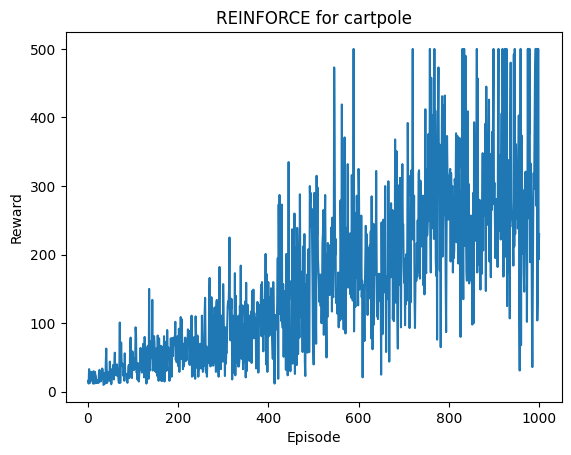

In [301]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE for cartpole")

# Display the plot
plt.show()

# Acrobot with REINFORCE

In [380]:
env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, _ = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    R = (R - R.mean()) / (R.std() + 1e-8)
    logp = torch.stack(logp)
    loss = -(logp * R).sum()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

        

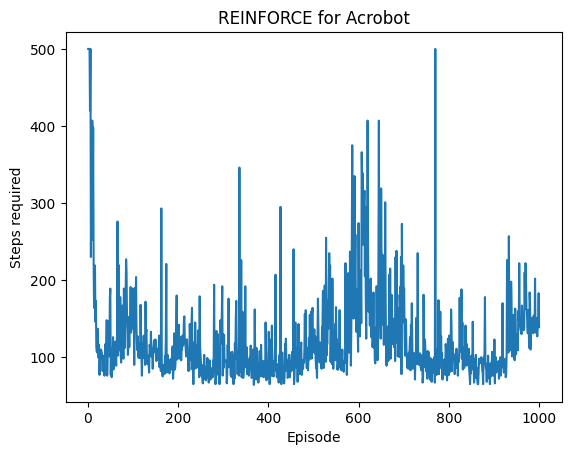

In [381]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Steps required")
plt.title("REINFORCE for Acrobot")

# Display the plot
plt.show()


# REINFORCE with baseline

In [443]:
from torch.distributions import Categorical, Normal, MultivariateNormal

class StateValue(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=32):
        super().__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        return self.linear2(self.linear3(self.linear1(x)))


def state_values(state_param, states_seen):
    st_vals = torch.zeros((len(states_seen)))
    for i, st in enumerate(states_seen):
        cur_val = state_param(st)
        st_vals[i] = cur_val
    return st_vals

# Solving Cartpole using REINFORCE with baseline

In [258]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
sv = StateValue(state_dim=obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
optimizer_sv = optim.Adam(sv.parameters(), lr=5e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, st = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    st = torch.as_tensor(st, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    state_value_approx = state_values(sv, st)
    # state_value_approx = torch.as_tensor(state_value_approx, dtype=torch.float32, device=device)
    delta = R - state_value_approx
    delta = delta.detach()
    # print(state_value_approx.requires_grad, delta.requires_grad)
    # break
    logp = torch.stack(logp)
    loss = -(logp * delta).sum()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    # State-value function approximater update
    # state_value_approx = torch.stack(state_value_approx)
    loss_sv = -(delta * state_value_approx).sum()
    optimizer_sv.zero_grad()
    loss_sv.backward()
    # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
    optimizer_sv.step()


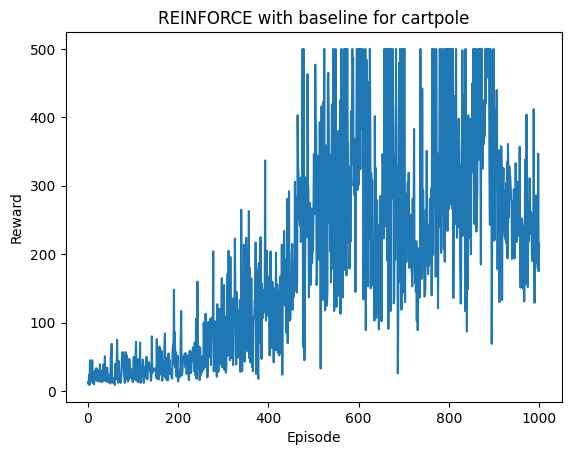

In [259]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()

# Action-Critic method batch implementation - not working

In [502]:
env = gym.make("CartPole-v1")
# env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim, hidden_dim=128)
sv = StateValue(state_dim=obs_dim, hidden_dim=128)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
optimizer_sv = optim.Adam(sv.parameters(), lr=5e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, st = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    # R = discounted_rewards(rw, discount_factor)
    # R = torch.as_tensor(R, dtype=torch.float32, device=device)
    
    st = torch.as_tensor(st, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    
    state_value_approx = state_values(sv, st)
    state_value_approx = torch.cat((state_value_approx, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
    # state_value_approx = torch.as_tensor(state_value_approx, dtype=torch.float32, device=device)
    rw = torch.as_tensor(rw, dtype=torch.float32, device=device)
    # rw = torch.cat((rw, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
    state_value_approx[-1] = 0
    delta = rw + discount_factor * state_value_approx[1:] - state_value_approx[:-1]
    delta = delta.detach()
    # print(state_value_approx.requires_grad, delta.requires_grad)
    # break
    logp = torch.stack(logp)
    # discounting = [discount_factor ** i for i in range(len(rw))]
    discounting = [1 ** i for i in range(len(rw))]
    discounting = torch.as_tensor(discounting, dtype=torch.float32, device=device)
    # delta = (delta - delta.mean()) / (delta.std() + 1e-8)
    # loss = -(discounting * logp * delta).mean()
    loss = -(logp * delta).mean()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    # State-value function approximater update
    # state_value_approx = torch.stack(state_value_approx)
    # loss_sv = (state_value_approx[:-1]).pow(2).mean()
    # delta.requires_grad = True
    loss_sv = -(delta * state_value_approx[:-1]).mean()
    optimizer_sv.zero_grad()
    loss_sv.backward()
    # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
    optimizer_sv.step()


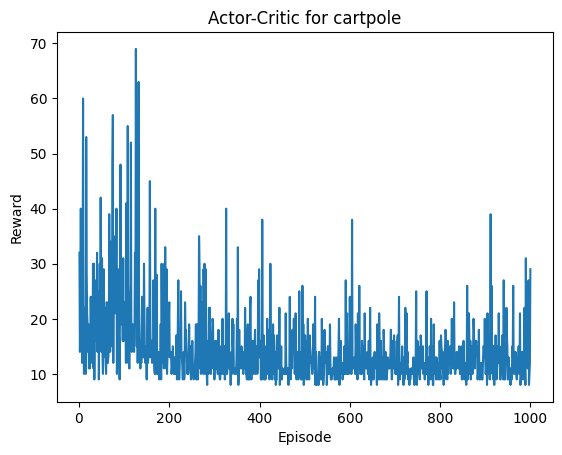

In [503]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Actor-Critic for cartpole")

# Display the plot
plt.show()

# Actor-Critic sequential

In [499]:
env = gym.make("CartPole-v1")
# env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim, hidden_dim=64)
sv = StateValue(state_dim=obs_dim, hidden_dim=64)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
optimizer_sv = optim.Adam(sv.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 5000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rewards = []
    obs, _ = env.reset()
    obs = torch.as_tensor(obs, dtype=torch.float32, device=device)
    state_value_approx = sv(obs)
    done = False
    t = 0
    while not done:
        obs_prev = obs
        logits = policy(torch.as_tensor(obs, dtype=torch.float32, device=device))
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        logp = dist.log_prob(action)
        obs, reward, terminated, truncated, info = env.step(action.item())
        obs = torch.as_tensor(obs, dtype=torch.float32, device=device)
        state_value_approx_new = sv(obs)
        if terminated:
            delta = reward - state_value_approx
        else:
            delta = reward + discount_factor * state_value_approx_new - state_value_approx
        delta = delta.detach()
        rewards.append(reward)
        loss = -(logp * delta ).mean()
        t += 1
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()

        # State-value function approximater update
        # state_value_approx = torch.stack(state_value_approx)
        # loss_sv = (state_value_approx[:-1]).pow(2).mean()
        # delta.requires_grad = True
        
        loss_sv = -(delta * sv(obs_prev))
        optimizer_sv.zero_grad()
        loss_sv.backward()
        # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
        optimizer_sv.step()
        
        state_value_approx = state_value_approx_new
        
        done = terminated or truncated
    total_reward.append(len(rewards))

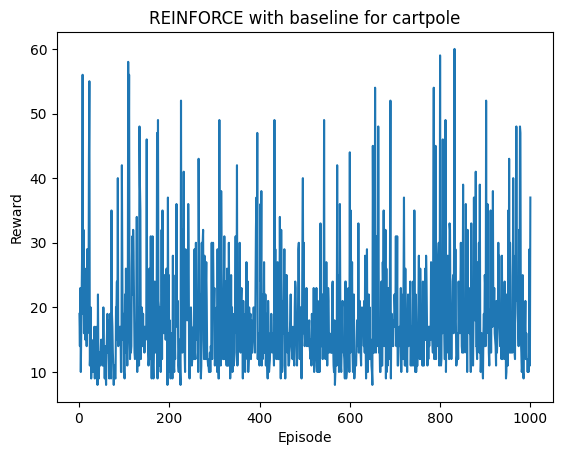

In [501]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()

# Key Take-aways:

- **Motivation for On-policy methods:** Off-policy methods converge faster but are computationally expensive and difficult to implement.
- **Methods:** Simplest approach is REINFORCE algorithm. Issue is high variance and actor-critic methods are developed to address the high variance issue.

# Key take-aways:
**On- vs. Off-policy motivation:**
- Off-policy methods (e.g. Q-learning, DQN, SAC) are more sample-efficient because they can reuse old data from replay buffers.
- But they are not necessarily more computationally expensive; in fact, on-policy methods often require more environment interactions (i.e., more compute in simulation).
- Off-policy methods can be harder to stabilize (divergence, distribution shift).
- On-policy methods (REINFORCE, PPO, A2C) are simpler conceptually, unbiased, and often more stable in practice — at the cost of discarding old trajectories.
  
**Methods:**
- REINFORCE = simplest on-policy algorithm. Direct policy gradient, unbiased, but high variance.
- Actor–Critic = introduces a value function (the critic) to reduce variance and improve stability.
- PPO / TRPO = further refinements that make actor–critic methods stable and scalable to large models (this is why PPO is the backbone of RLHF).

# On- vs Off-Policy: Key Take-aways

## Why On-policy?

**Off-policy (Q-learning, DQN, SAC)**

✅ More sample-efficient (reuse replay buffer).

⚠️ Can be harder to stabilize (distribution shift, divergence).

⚖️ Not inherently more “computationally expensive” — often cheaper per gradient step.

**On-policy (REINFORCE, A2C, PPO)**

✅ Simple & stable (fresh data, unbiased gradients).

❌ Less sample-efficient (must discard old trajectories).

🚀 Easier to scale to large policies (why PPO is used in RLHF).

## Algorithm lineage:

- REINFORCE → simplest on-policy policy gradient; high variance.
- Actor–Critic → adds a value function to reduce variance & improve learning.
- PPO / TRPO → clip or constrain updates for stability at scale.

# Actor-Critic with eligibility trace

In [527]:
def discounted_advantage(rw, val_approx, discount_factor, history_decay, history_len):
    R = []
    for i in range(len(rw)):
        discounted_reward = 0
        for j in range(i, min(len(rw), history_len)):
            discounted_reward += (history_decay ** (j - i)) * (rw[j] + discount_factor * val_approx[j + 1] - val_approx[j])
        R.append(discounted_reward)
    return R

env = gym.make("CartPole-v1")
# env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim, hidden_dim=64)
sv = StateValue(state_dim=obs_dim, hidden_dim=64)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
optimizer_sv = optim.Adam(sv.parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
history_decay = 0.99
total_reward = []
history_len = 50
for ep in range(episodes):
    rw, logp, st = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    # R = discounted_rewards(rw, discount_factor)
    # R = torch.as_tensor(R, dtype=torch.float32, device=device)
    
    st = torch.as_tensor(st, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    
    state_value_approx = state_values(sv, st)
    state_value_approx = torch.cat((state_value_approx, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
    # state_value_approx = torch.as_tensor(state_value_approx, dtype=torch.float32, device=device)
    rw = torch.as_tensor(rw, dtype=torch.float32, device=device)
    # rw = torch.cat((rw, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
    state_value_approx[-1] = 0
    delta = discounted_advantage(rw, state_value_approx, discount_factor, history_decay, history_len)
    delta = torch.as_tensor(delta, dtype=torch.float32, device=device)
    # print(state_value_approx.requires_grad, delta.requires_grad)
    # break
    logp = torch.stack(logp)
    # discounting = [discount_factor ** i for i in range(len(rw))]
    discounting = [1 ** i for i in range(len(rw))]
    discounting = torch.as_tensor(discounting, dtype=torch.float32, device=device)
    # delta = (delta - delta.mean()) / (delta.std() + 1e-8)
    # loss = -(discounting * logp * delta).mean()
    loss = -(logp * delta).mean()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    # State-value function approximater update
    # state_value_approx = torch.stack(state_value_approx)
    # loss_sv = (state_value_approx[:-1]).pow(2).mean()
    # delta.requires_grad = True
    loss_sv = -(delta * state_value_approx[:-1]).mean()
    optimizer_sv.zero_grad()
    loss_sv.backward()
    # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
    optimizer_sv.step()


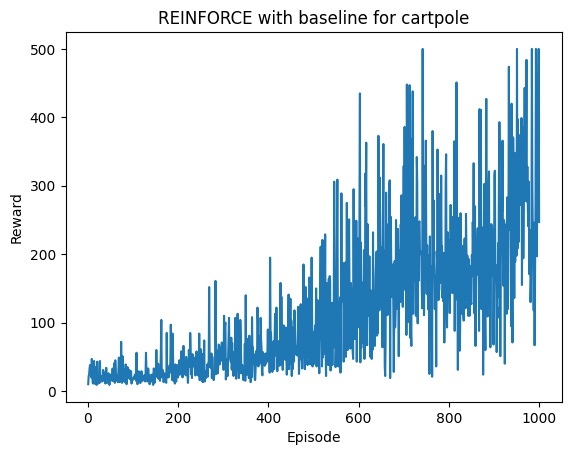

In [526]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()

# Proximal policy optimization (PPO)



 - Imporves upon TRPO. Stability issue with TRPO covered in https://arxiv.org/pdf/2102.06234
 - PPO extends TRPO by replacing its hard KL-divergence constraint with a simpler clipped surrogate objective that approximates the trust region effect.

In [ ]:
class PPO(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=32):
        super.__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, out_dim)
    def forward(self, x):
        return self.linear3(self.linear2(self.linear1(x)))

    def sample_action(self, probs):
        # probs = torch.tensor(p)
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()
        return sample